In [2]:
!pip install arviz
!pip install pymc3==3.8

In [0]:
from pymc3 import Poisson, Uniform, Categorical, Normal, MvNormal
from pymc3 import *
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Load data

In [0]:
df_train = pd.read_csv('/content/synthetic-3C2D.csv',index_col=0)
df_train=df_train.reset_index()
w_true = np.array([[1,-2,2],
                  [3,1,0],])
b_true = np.array([-1,5,2]).reshape((1,3))

In [5]:
df_train.columns

Index(['index', 'longitude', 'latitude', 'coordinate', 'true class',
       'feature1', 'feature2', 'true target', 'noisy target'],
      dtype='object')

In [0]:
x = df_train[['feature1', 'feature2']]
y_noisy = df_train['noisy target']

In [0]:
x1 = df_train['feature1']
x2 = df_train['feature2']

#Model with z - no breaking symmetry

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model:
    #assume five classesa
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    w_1 = Normal('w_1', mu=0, sd=1, shape=(k))
    w_2 = Normal('w_2', mu=0, sd=1, shape=(k))
    b = Normal('b',mu=0,sd=1, shape=(k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', w_1[z])
    w2 = pm.Deterministic('w2', w_2[z])
    b1 = pm.Deterministic('b1', b[z])
    
    y = b1 + w1* x1 + w2*x2
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y, sd=σ, observed=y_noisy)

In [18]:
with model:
    trace = pm.sample(10000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, b, w_2, w_1, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [49:22<00:00, 10.13draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19cc1506d8>,
      dtype=object)

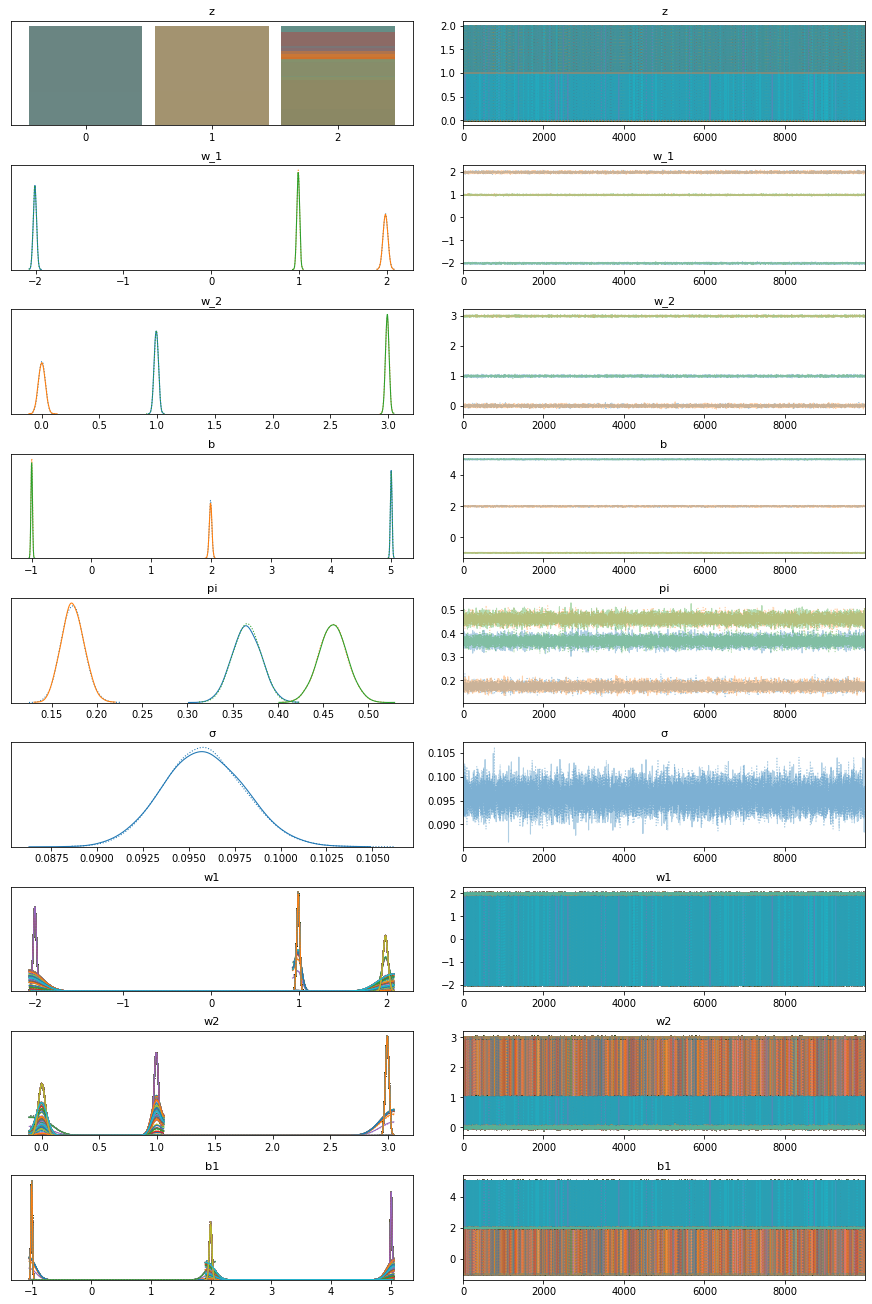

In [19]:
pm.traceplot(trace)

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bce74390>,
      dtype=object)

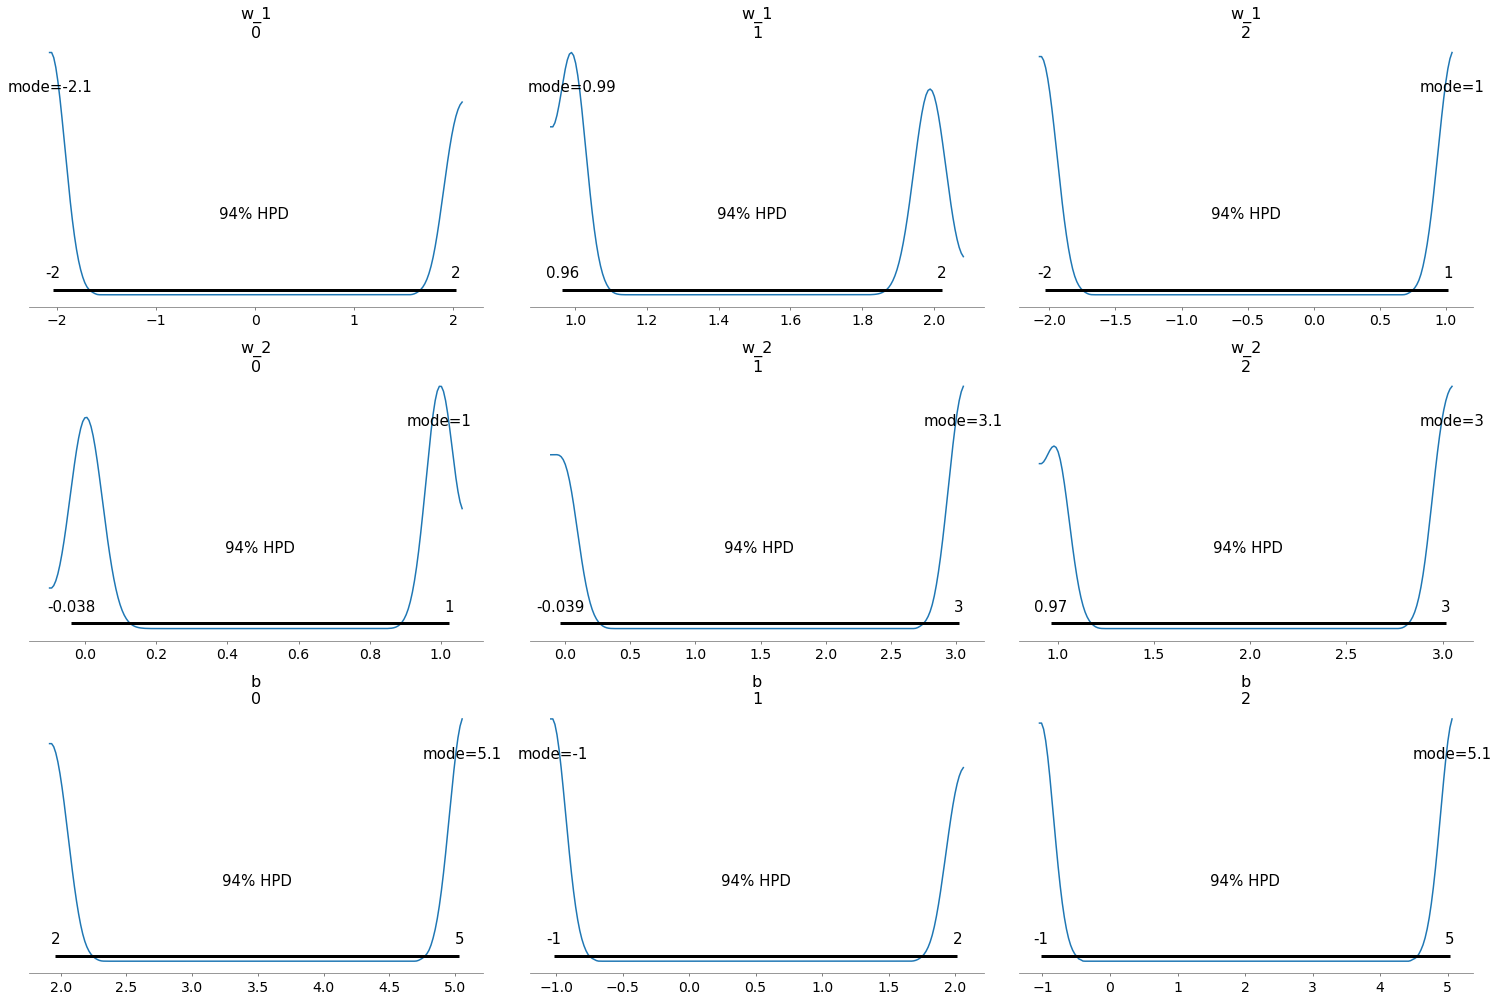

In [21]:
pm.plot_posterior(trace,varnames=['w_1','w_2','b'], point_estimate='mode')

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bdb25898>,
      dtype=object)

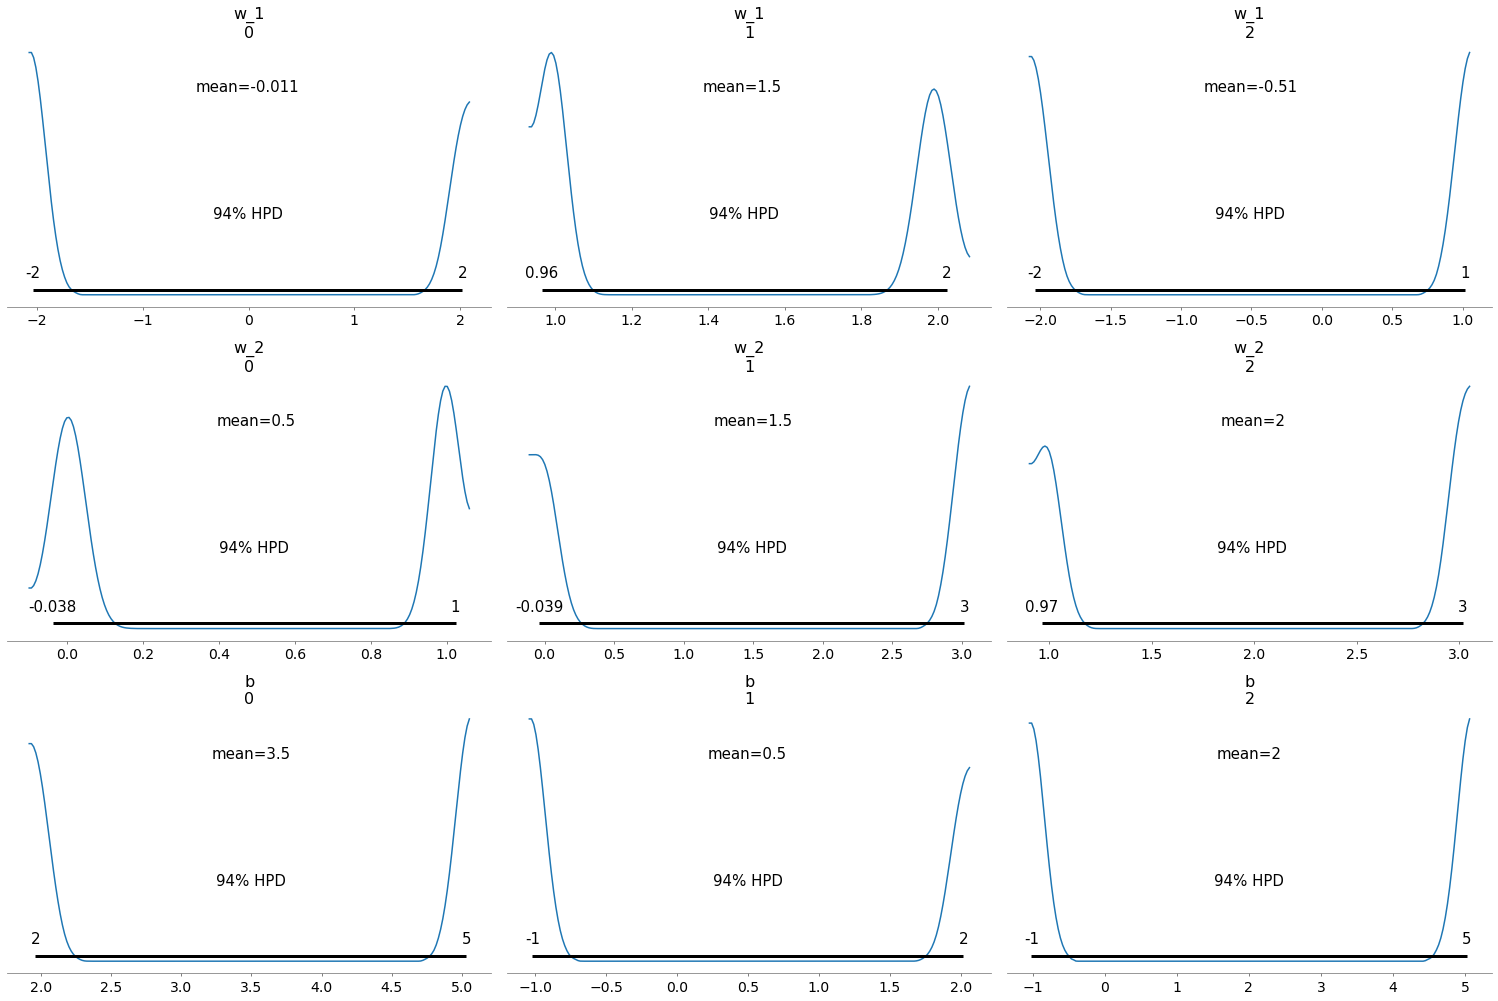

In [22]:
pm.plot_posterior(trace,varnames=['w_1','w_2','b'], point_estimate='mean')

## get most likely estimation from samples

In [27]:
w_true, b_true

(array([[ 1, -2,  2],
        [ 3,  1,  0]]), array([[-1,  5,  2]]))

In [0]:
w1_map = trace['w_1'][-5000:].mean(axis=0).round()
w2_map = trace['w_2'][-5000:].mean(axis=0).round()
b_map = trace['b'][-5000:].mean(axis=0).round()
from scipy import stats
z_map, counts = stats.mode(trace['z'][-5000:,:])
z_map = z_map.flatten()
confidence = np.round((counts/5000),decimals=2).reshape(1000,)
y_pred = (b_map[z_map]) + w1_map[z_map]*(x1.values) + w2_map[z_map]*(x2.values) 

In [104]:
w1_map

array([ 2.,  1., -2.])

In [105]:
w2_map

array([0., 3., 1.])

In [106]:
b_map

array([ 2., -1.,  5.])

Rearrange the order of predicted class according to the predicted w and b, save to csv

In [0]:
df_model1 = df_train.copy()
df_model1['predicted z'] = z_map
df_model1['confidence'] = confidence
df_model1['predicted y'] = y_pred
df_model1['reordered predicted z'] = (df_model1['predicted z']+1).map({1:3,2:1,3:2})

In [0]:
df_model1.to_csv('model1-3C2D.csv')

## confusion matrix of predicted z

In [0]:
y_actual = df_model1['true class']
y_pred = df_model1['reordered predicted z']

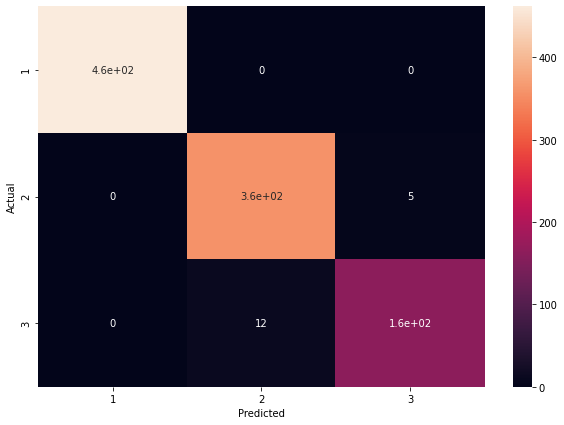

In [93]:
import seaborn as sn
import matplotlib.pyplot as plt
y_actu = pd.Series(y_actual.values, name='Actual')
y_pred = pd.Series(y_pred.values, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize = (10,7))
sn.heatmap(df_confusion, annot=True)

## confidence of z

In [99]:
df_model1['confidence'].describe()

count    1000.000000
mean        0.985610
std         0.067263
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: confidence, dtype: float64

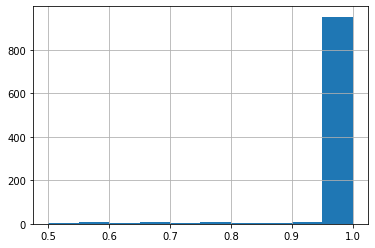

In [97]:
df_model1['confidence'].hist()

Most z has very high confidence, I can check for the geographic reconstruction with the csv file.

Because the posterior plot suffers from symmetry problem, try to break symmetry in the next model

#Model with z, break symmetry by ordered transform

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model_2:
    #assume five classesa
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    w_1 = Normal('w_1', mu=0, sd=1, shape=(k), transform=Ordered(), testval=[-2,1,2])
    w_2 = Normal('w_2', mu=0, sd=1, shape=(k))
    b = Normal('b',mu=0,sd=1, shape=(k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', w_1[z])
    w2 = pm.Deterministic('w2', w_2[z])
    b1 = pm.Deterministic('b1', b[z])
    
    y = b1 + w1* x1 + w2*x2
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y, sd=σ, observed=y_noisy)

In [107]:
with model_2:
    trace_2 = pm.sample(10000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, b, w_2, w_1, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 22 divergences: 100%|██████████| 30000/30000 [53:02<00:00,  9.43draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19ad2fbb70>,
      dtype=object)

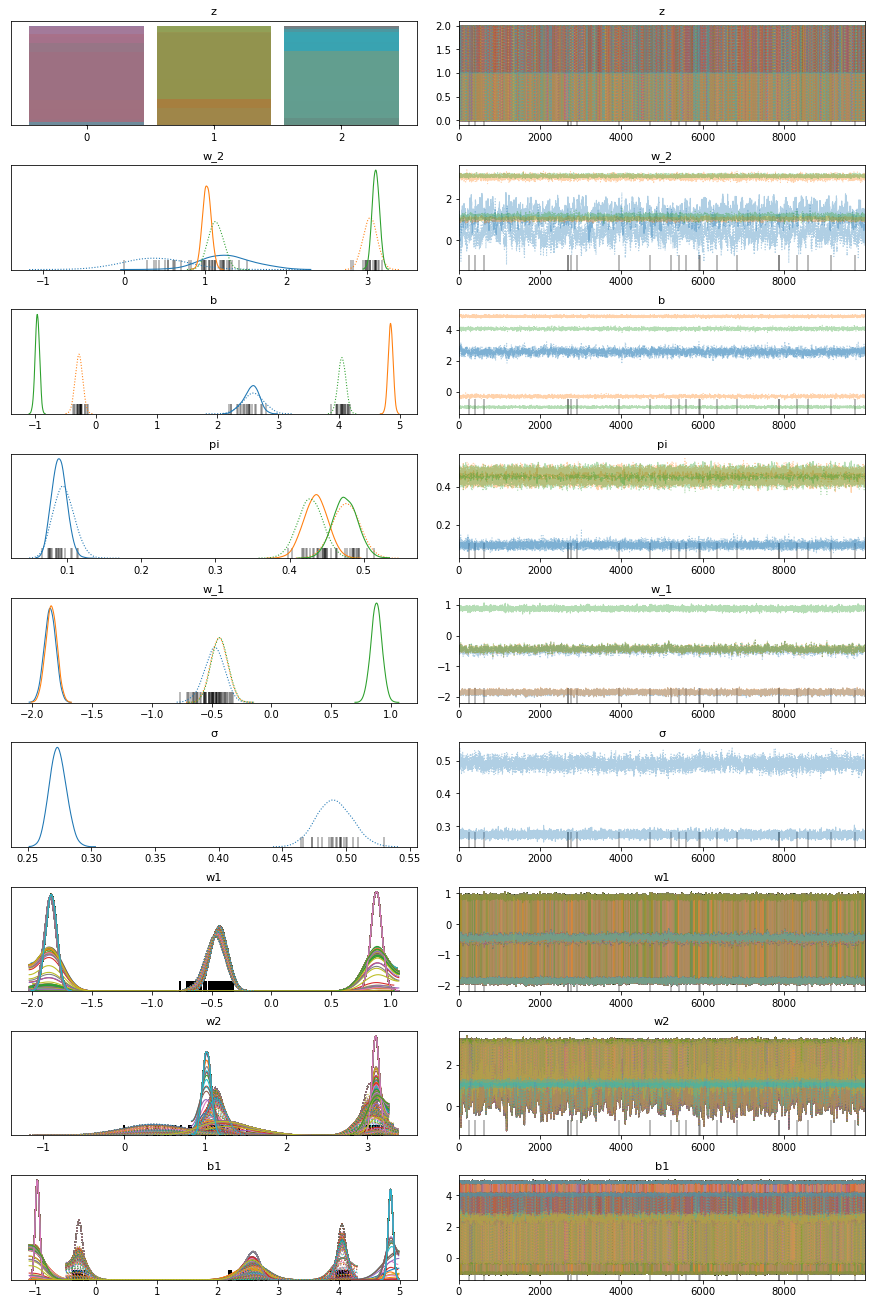

In [108]:
pm.traceplot(trace_2)

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f199d8afac8>,
      dtype=object)

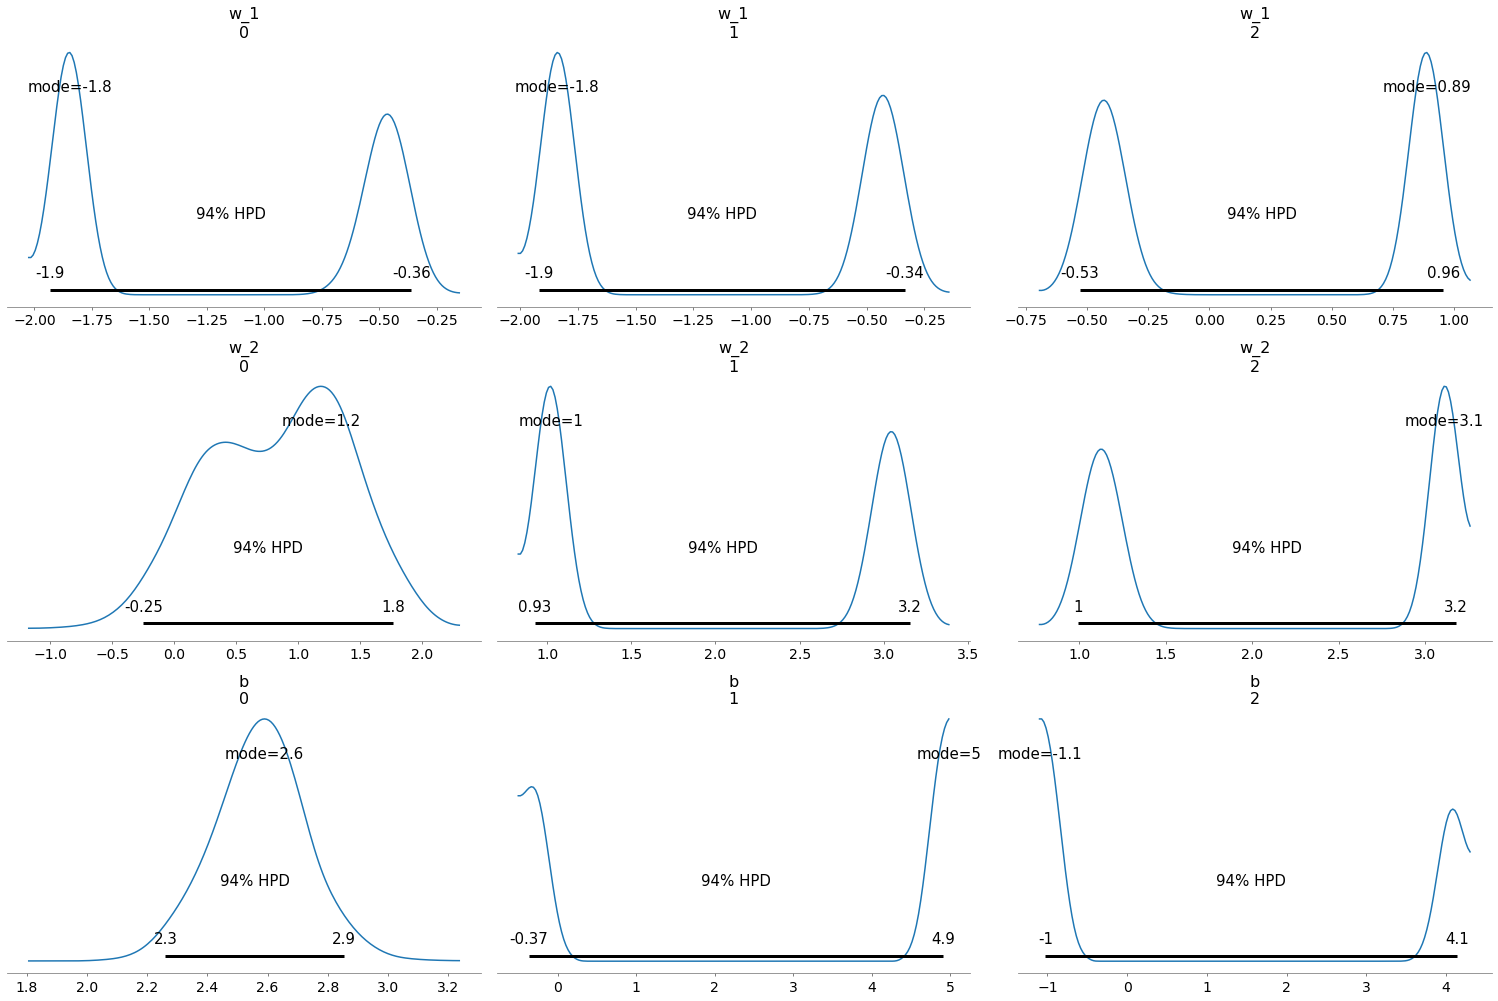

In [109]:
pm.plot_posterior(trace_2,varnames=['w_1','w_2','b'], point_estimate='mode')

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f199e86bdd8>,
      dtype=object)

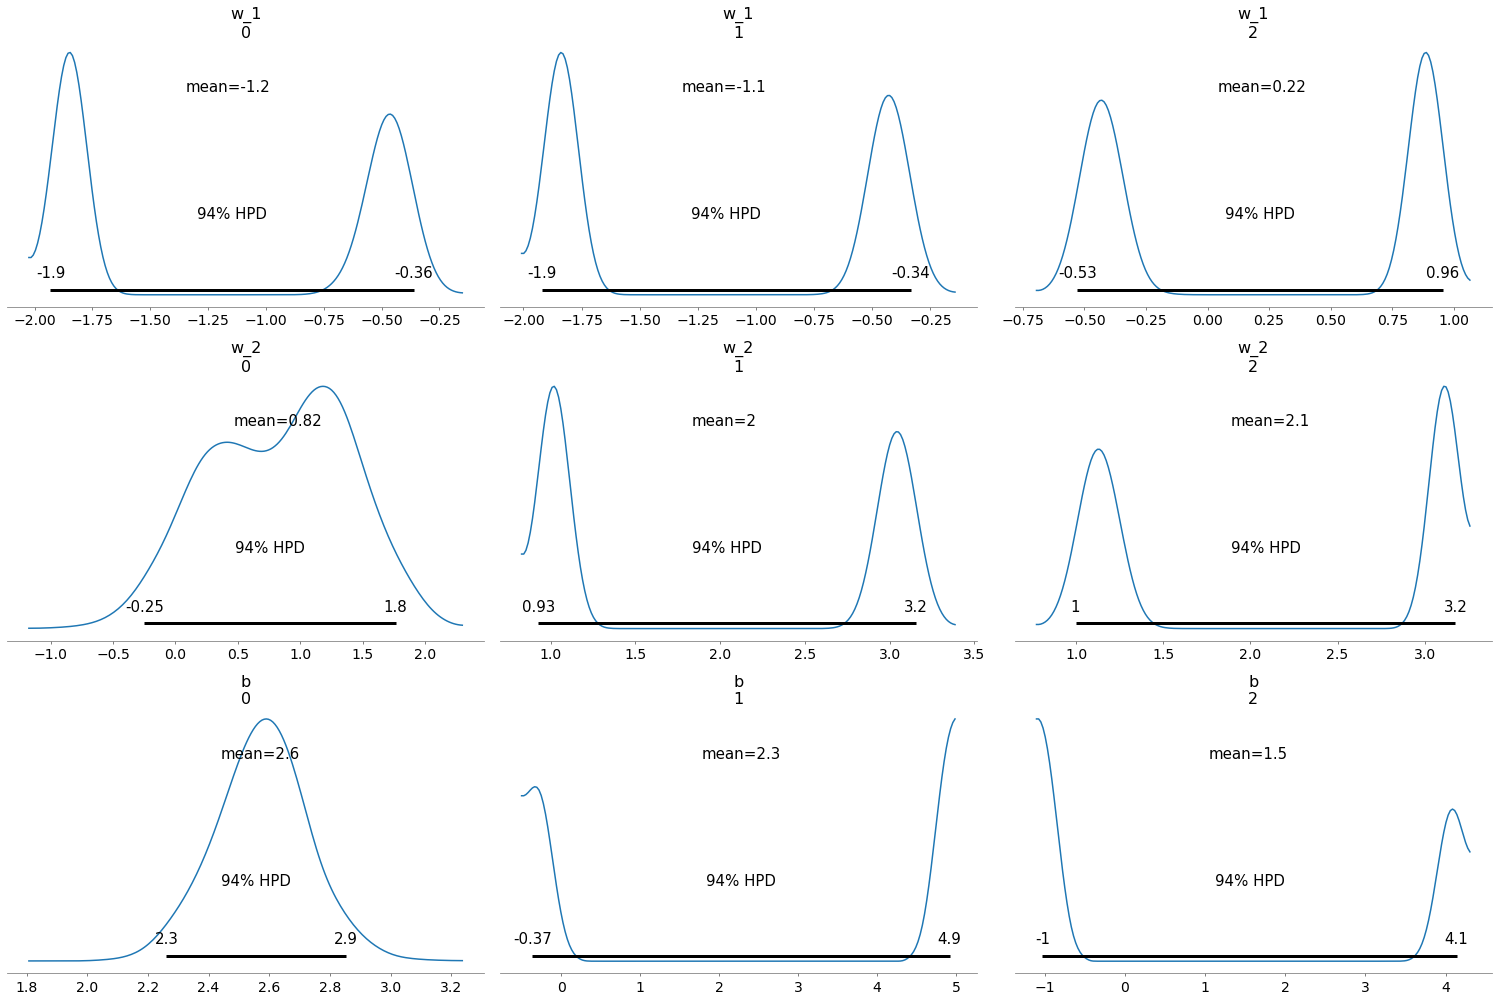

In [110]:
pm.plot_posterior(trace_2,varnames=['w_1','w_2','b'], point_estimate='mean')

## Most likely params

In [0]:
w1_map = trace_2['w_1'][-5000:].mean(axis=0).round()
w2_map = trace_2['w_2'][-5000:].mean(axis=0).round()
b_map = trace_2['b'][-5000:].mean(axis=0).round()
from scipy import stats
z_map, counts = stats.mode(trace_2['z'][-5000:,:])
z_map = z_map.flatten()
confidence = np.round((counts/5000),decimals=2).reshape(1000,)
y_pred = (b_map[z_map]) + w1_map[z_map]*(x1.values) + w2_map[z_map]*(x2.values) 

In [113]:
w_true,b_true

(array([[ 1, -2,  2],
        [ 3,  1,  0]]), array([[-1,  5,  2]]))

In [114]:
w1_map,w2_map

(array([-0., -0., -0.]), array([0., 3., 1.]))

In [115]:
b_map

array([ 3., -0.,  4.])

# tt.sort

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model3:
    #assume five classesa
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    w_1 = Normal('w_1', mu=0, sd=1, shape=(k))
    w_2 = Normal('w_2', mu=0, sd=1, shape=(k))
    b = Normal('b',mu=0,sd=1, shape=(k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', tt.sort(w_1)[z])
    w2 = pm.Deterministic('w2', w_2[z])
    b1 = pm.Deterministic('b1', b[z])
    
    y = b1 + w1* x1 + w2*x2
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y, sd=σ, observed=y_noisy)

In [8]:
with model3:
    trace3 = pm.sample(20000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, b, w_2, w_1, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 60000/60000 [2:11:31<00:00,  7.60draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
w_true,b_true

(array([[ 1, -2,  2],
        [ 3,  1,  0]]), array([[-1,  5,  2]]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cfce30630>,
      dtype=object)

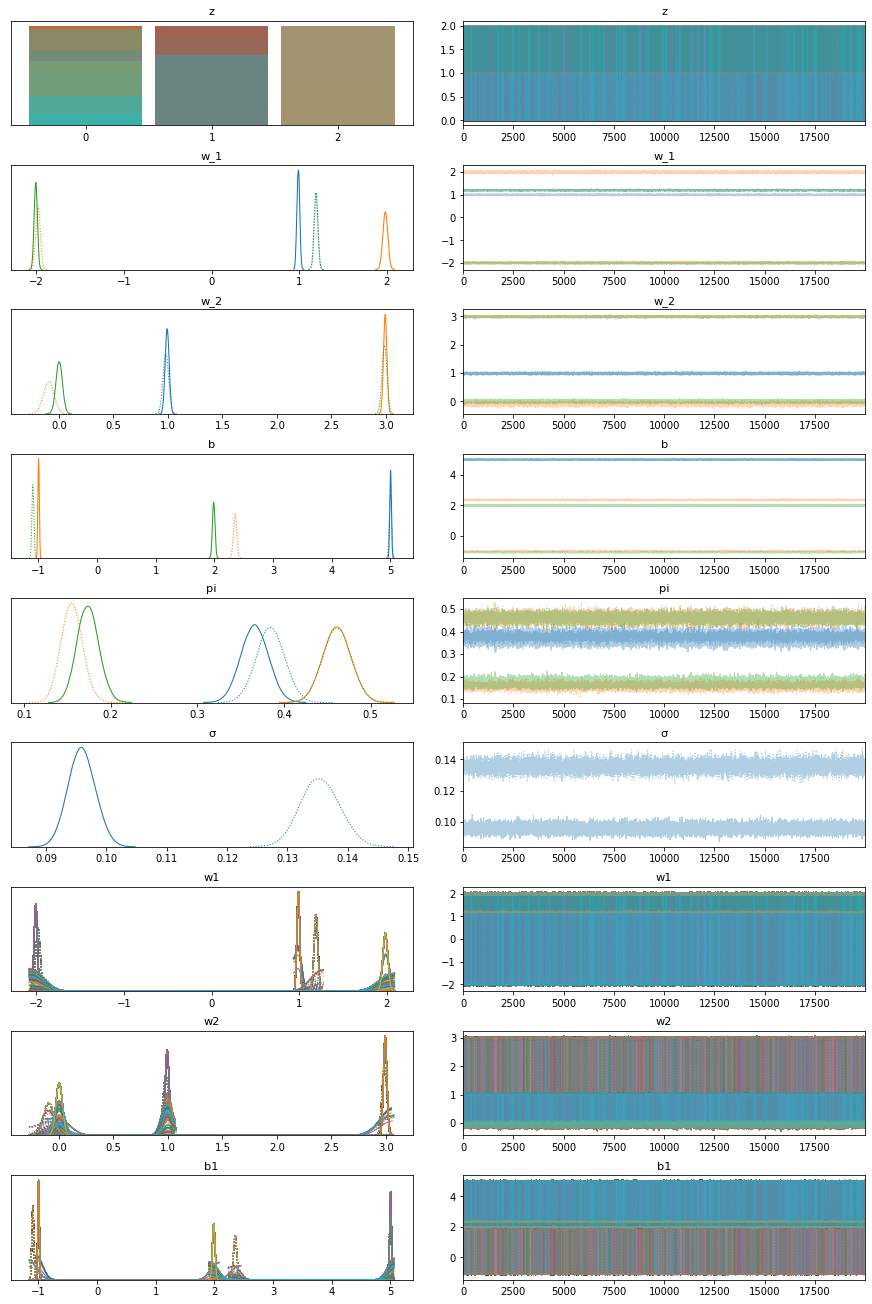

In [9]:
pm.traceplot(trace3)

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ceade7198>,
      dtype=object)

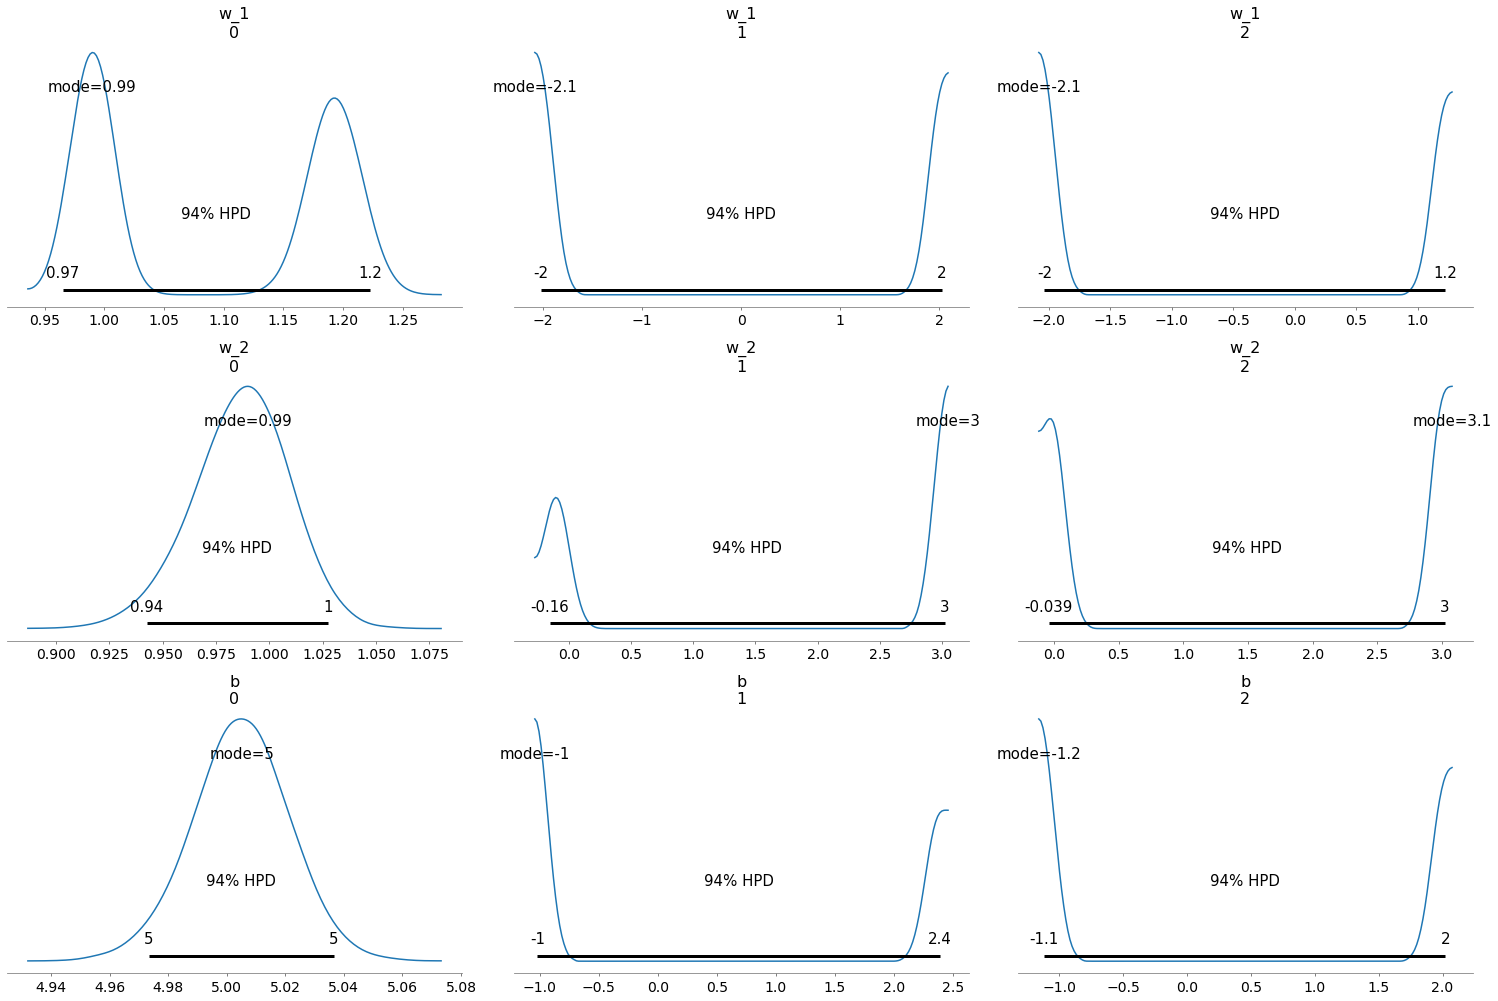

In [11]:
pm.plot_posterior(trace3,varnames=['w_1','w_2','b'], point_estimate='mode')

#Use sort on the original distribution

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model4:
    #assume five classesa
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    w_1 = tt.sort(Normal('w_1', mu=0, sd=1, shape=(k)))
    w_2 = Normal('w_2', mu=0, sd=1, shape=(k))
    b = Normal('b',mu=0,sd=1, shape=(k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', w_1[z])
    w2 = pm.Deterministic('w2', w_2[z])
    b1 = pm.Deterministic('b1', b[z])
    
    y = b1 + w1* x1 + w2*x2
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y, sd=σ, observed=y_noisy)

In [9]:
with model4:
    trace4 = pm.sample(10000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, b, w_2, w_1, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [1:07:25<00:00,  7.42draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f26b3a25ba8>,
      dtype=object)

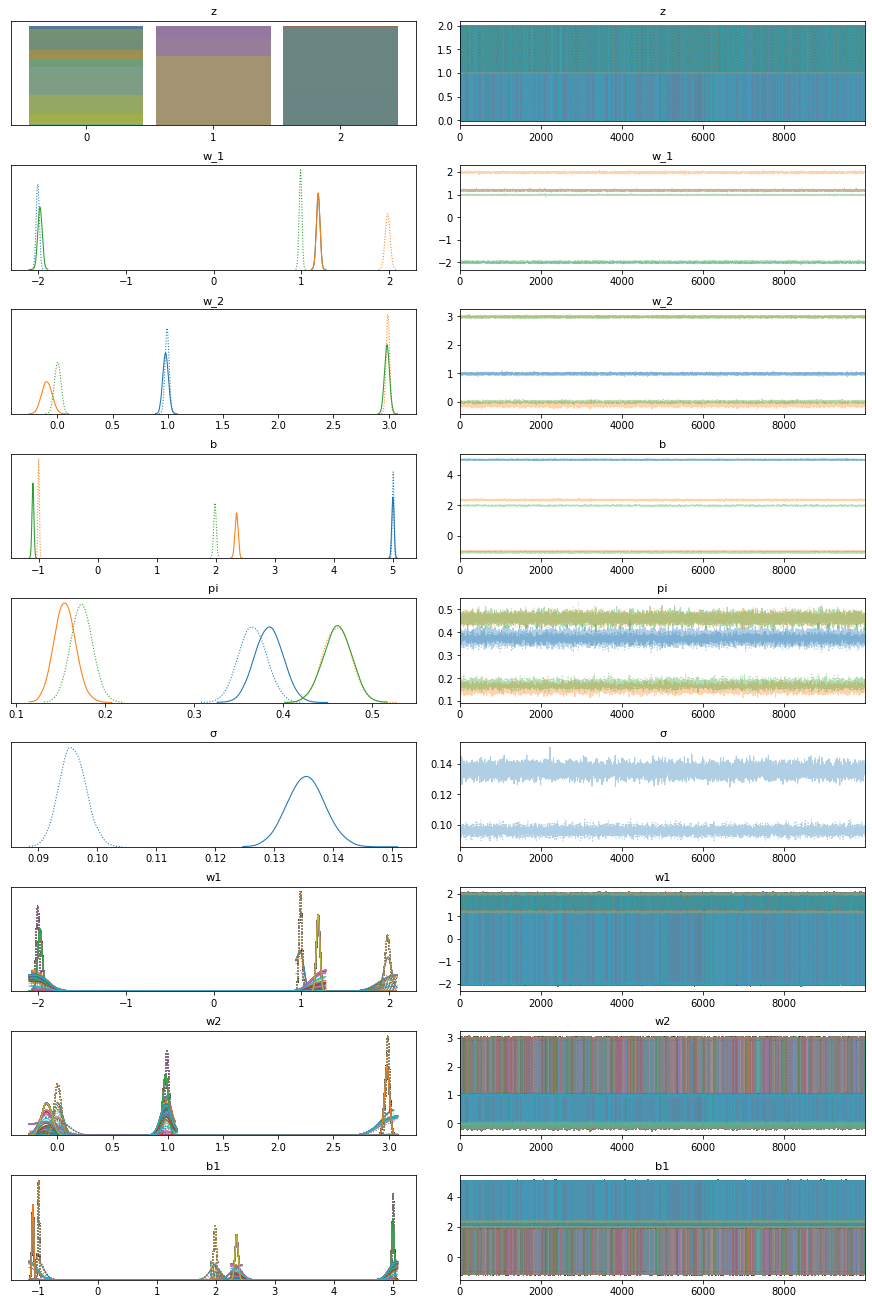

In [10]:
pm.traceplot(trace4)

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f26a209d6d8>,
      dtype=object)

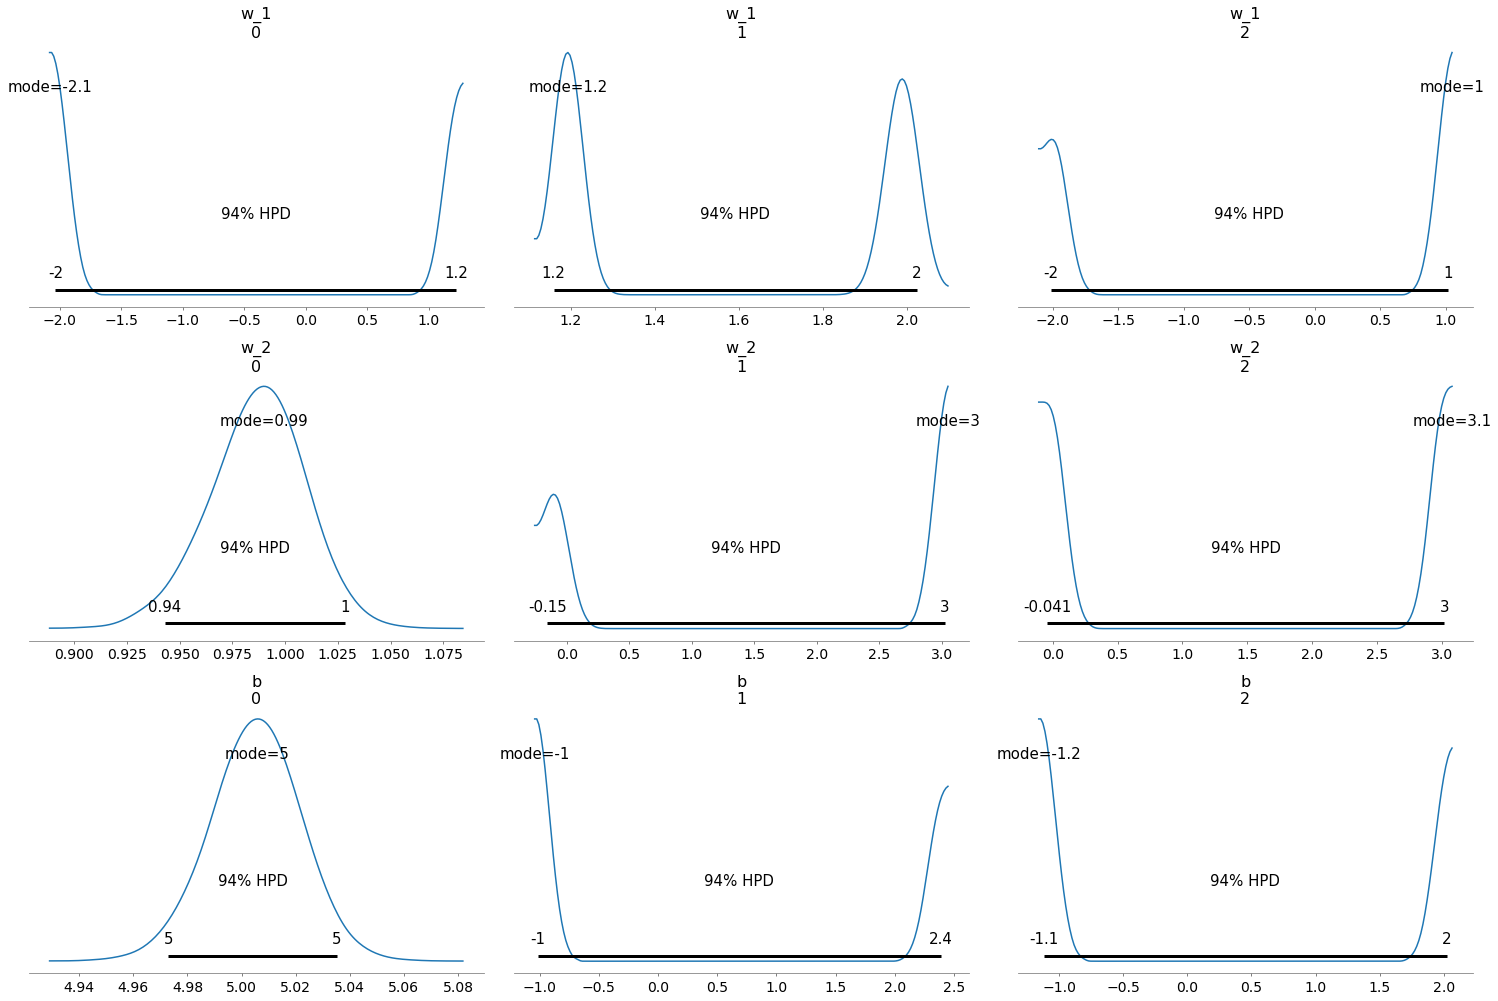

In [11]:
pm.plot_posterior(trace4,varnames=['w_1','w_2','b'], point_estimate='mode')

# enforce order

In [0]:
import theano.tensor as tt
from pymc3.distributions.transforms import Ordered,LogOdds
k=3
m= x.shape[1]
n= x.shape[0]
# num_classes = k
# num_features = m

with Model() as model4:
    #assume five classes
    pi = pm.Dirichlet('pi',np.array([1]*k))
    z = Categorical(name='z',p=pi, shape=(n))
    #regression parameter
    #5 categories: 5 rows in shape, 5 features: 5 columns
    w = Normal('w', mu=0, sd=1, shape=(m,k))

        # Enforce ordering of markers
    switching = tt.switch(w[:,1] - w[:,0] < 0, -np.inf, 0)
    for i in range(1, k-1):
        switching += tt.switch(w[:,i+1]-w[:,i] < 0, -np.inf, 0)

    pm.Potential('order', switching)

    b = Normal('b',mu=0,sd=1, shape=(1,k))
    σ  = pm.HalfCauchy('σ',0.2)
    
    w1 = pm.Deterministic('w1', w[z,:])
    b1 = pm.Deterministic('b1', b[z,:])
    
    y = b1 + w1*x
    
    #sd is noise in here
    # use log of price in the actual model
    price = pm.Normal('price', mu=y.T, sd=σ, observed=y_noisy)

In [0]:
with model4:
    trace3 = pm.sample(20000, tune=10000)

In [0]:
pm.plot_posterior(trace4,varnames=['w','b'], point_estimate='mode')

In [0]:
pm.traceplot(trace4)